In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline
version = '02'

Using TensorFlow backend.


In [2]:
def play_bell():
    import winsound
    duration = 200  # millisecond
    freq = 440  # Hz
    for i in range(5):
        winsound.Beep(int(freq*(i/2+1)), duration)

## Dataset loading

In [3]:
right = pd.read_csv("../data/right.txt", header=None).values.tolist()
left = pd.read_csv("../data/left.txt", header=None).values.tolist()

## Pre-processing

In [19]:
batch_size = 200
batch_right = [right[i:i + batch_size] for i in range(0, len(right), batch_size)]
batch_left = [left[i:i + batch_size] for i in range(0, len(left), batch_size)]

X = np.array(batch_right + batch_left)
y = np.array([0]*len(batch_right) + [1]*len(batch_left))

In [20]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (600, 200, 2)
y shape: (600,)


In [21]:
X_diff = X[:,:-1,:].copy()
X_diff[:,:,0] = np.diff(X[:,:,0])
X_diff[:,:,1] = np.diff(X[:,:,1])

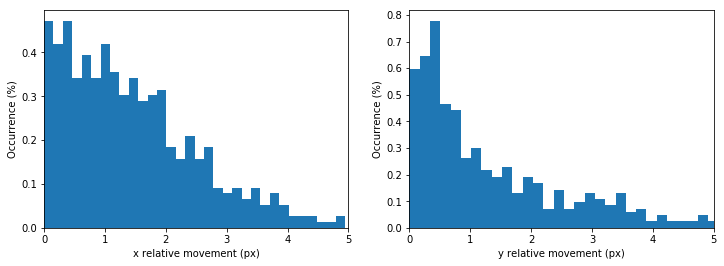

In [22]:
sigma_x = np.std(X_diff[:,:,0], axis=1)
sigma_y = np.std(X_diff[:,:,1], axis=1)
mask = (sigma_x>0.1)*(sigma_y>0.1)

X_filt = X_diff[mask]
y_filt = y[mask]

x_std = 3.398 # np.mean(np.std(X_filt[:,:,0], axis=1))
y_std = 2.926 # np.mean(np.std(X_filt[:,:,1], axis=1))

X_filt[:,:,0] = X_filt[:,:,0] / x_std
X_filt[:,:,1] = X_filt[:,:,1] / y_std

sigma_x_filt = np.std(X_filt[:,:,0], axis=1)
sigma_y_filt = np.std(X_filt[:,:,1], axis=1)


fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12, 4))
ax1.hist(sigma_x_filt, bins=50, density=True)
ax2.hist(sigma_y_filt, bins=50, density=True)
for ax in (ax1,ax2):
    ax.set_xlim(0,5)
    ax.set_ylabel('Occurrence (%)')
    #ax.set_yticks(np.arange(0,0.41,0.1))
ax1.set_xlabel('x relative movement (px)')
ax2.set_xlabel('y relative movement (px)')

fig.savefig(f'../plots/relative_movement_hist_corrected.png', bbox_inches='tight')

In [8]:
np.mean(np.std(X_filt[:,:,0], axis=1))

1.4900517595356684

## Training/dev/test set splitting

In [10]:
X = X_filt
y = y_filt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, shuffle=True)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1, shuffle=True)

## Model definition

In [11]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_dev.shape[1], 2)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               265216    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________


## Model training

In [12]:
adam = Adam(lr=0.0001)
chk = ModelCheckpoint(f'../models/best_model_{version}.pkl', monitor='acc', save_best_only=True, mode='max', verbose=0) #monitor='val_acc'
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history_training = model.fit(X_train, y_train, epochs=200, batch_size=64, callbacks=[chk], validation_data=(X_dev, y_dev))
play_bell()

Instructions for updating:
Use tf.cast instead.
Train on 345 samples, validate on 74 samples
Epoch 1/200
345/345 [==============================] - 3s 7ms/step - loss: 0.6871 - acc: 0.5565 - val_loss: 0.6996 - val_acc: 0.3919
Epoch 2/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6844 - acc: 0.5681 - val_loss: 0.7020 - val_acc: 0.3784
Epoch 3/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6816 - acc: 0.5652 - val_loss: 0.7036 - val_acc: 0.3784
Epoch 4/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6796 - acc: 0.5594 - val_loss: 0.7049 - val_acc: 0.3919
Epoch 5/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6775 - acc: 0.5507 - val_loss: 0.7056 - val_acc: 0.4189
Epoch 6/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6756 - acc: 0.5478 - val_loss: 0.7060 - val_acc: 0.4189
Epoch 7/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6741 - acc: 0.5478 - val_loss: 0

Epoch 60/200
345/345 [==============================] - 2s 5ms/step - loss: 0.5464 - acc: 0.7043 - val_loss: 0.5993 - val_acc: 0.7297
Epoch 61/200
345/345 [==============================] - 2s 5ms/step - loss: 0.5889 - acc: 0.6928 - val_loss: 0.6533 - val_acc: 0.6892
Epoch 62/200
345/345 [==============================] - 2s 5ms/step - loss: 0.5949 - acc: 0.6580 - val_loss: 0.6611 - val_acc: 0.6216
Epoch 63/200
345/345 [==============================] - 2s 5ms/step - loss: 0.5886 - acc: 0.6493 - val_loss: 0.6403 - val_acc: 0.6757
Epoch 64/200
345/345 [==============================] - 2s 5ms/step - loss: 0.6019 - acc: 0.6899 - val_loss: 0.6188 - val_acc: 0.6892
Epoch 65/200
345/345 [==============================] - 2s 5ms/step - loss: 0.5633 - acc: 0.6783 - val_loss: 0.6198 - val_acc: 0.7297
Epoch 66/200
345/345 [==============================] - 2s 5ms/step - loss: 0.5484 - acc: 0.7130 - val_loss: 0.5910 - val_acc: 0.7432
Epoch 67/200
345/345 [==============================] - 2s 6ms

Epoch 121/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3820 - acc: 0.8000 - val_loss: 0.5781 - val_acc: 0.7838
Epoch 122/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3929 - acc: 0.8261 - val_loss: 0.5625 - val_acc: 0.7703
Epoch 123/200
345/345 [==============================] - 3s 7ms/step - loss: 0.3622 - acc: 0.8348 - val_loss: 0.5711 - val_acc: 0.6757
Epoch 124/200
345/345 [==============================] - 2s 7ms/step - loss: 0.3538 - acc: 0.8145 - val_loss: 0.5607 - val_acc: 0.7703
Epoch 125/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3415 - acc: 0.8435 - val_loss: 0.5894 - val_acc: 0.7973
Epoch 126/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3544 - acc: 0.8435 - val_loss: 0.5596 - val_acc: 0.7703
Epoch 127/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3558 - acc: 0.8522 - val_loss: 0.5654 - val_acc: 0.7838
Epoch 128/200
345/345 [==============================] 

345/345 [==============================] - 2s 6ms/step - loss: 0.2940 - acc: 0.8638 - val_loss: 0.5754 - val_acc: 0.7838
Epoch 182/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3042 - acc: 0.8551 - val_loss: 0.6070 - val_acc: 0.7703
Epoch 183/200
345/345 [==============================] - 2s 6ms/step - loss: 0.2995 - acc: 0.8522 - val_loss: 0.5699 - val_acc: 0.7568
Epoch 184/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3232 - acc: 0.8377 - val_loss: 0.5683 - val_acc: 0.7703
Epoch 185/200
345/345 [==============================] - 2s 7ms/step - loss: 0.3121 - acc: 0.8638 - val_loss: 0.5764 - val_acc: 0.8108
Epoch 186/200
345/345 [==============================] - 2s 7ms/step - loss: 0.3547 - acc: 0.8377 - val_loss: 0.5950 - val_acc: 0.7973
Epoch 187/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3220 - acc: 0.8493 - val_loss: 0.6594 - val_acc: 0.6757
Epoch 188/200
345/345 [==============================] - 2s 6ms/step 

## Training history plot

Best accuracy on the dev set: 82.4%
Best accuracy on the training set: 89.3%


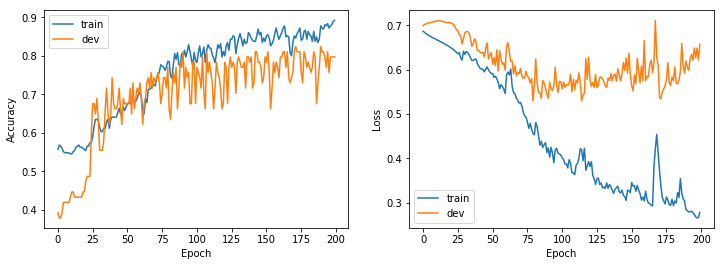

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(history_training.history['acc'], label='train')
ax1.plot(history_training.history['val_acc'], label='dev')

ax2.plot(history_training.history['loss'], label='train')
ax2.plot(history_training.history['val_loss'], label='dev')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.legend()
ax2.legend()

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

best_acc = max(history_training.history['val_acc'])
print(f'Best accuracy on the dev set: {best_acc*100:.1f}%')
best_acc_training = max(history_training.history['acc'])
print(f'Best accuracy on the training set: {best_acc_training*100:.1f}%')
fig.savefig(f'../plots/model_{version}.png', bbox_inches='tight')

## Evaluation of the model

In [14]:
model = load_model(f'../models/best_model_{version}.pkl') # load best model

In [15]:
dev_preds = model.predict_classes(X_dev)
acc_dev = accuracy_score(y_dev, dev_preds)
print(f'Accuracy on the dev set: {acc_dev*100:.1f}%')

training_preds = model.predict_classes(X_train)
acc_training = accuracy_score(y_train, training_preds)
print(f'Accuracy on the training set: {acc_training*100:.1f}%')

Accuracy on the dev set: 79.7%
Accuracy on the training set: 89.0%


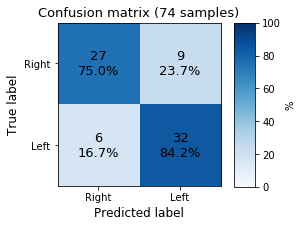

In [24]:
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_dev, dev_preds)
#cm = confusion_matrix(y_train, training_preds)

classes=['Right', 'Left']
fig, ax = plt.subplots(1, figsize=(3,3))
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

cm_norm = cm / cm.sum(axis=1)*100
im = ax.imshow(cm_norm, cmap='Blues', interpolation='none', clim=(0,100))
ax.set_title(f'Confusion matrix ({y_dev.shape[0]} samples)', size=13)


for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, f'{cm[i,j]}\n{cm_norm[i, j]:.1f}%', size=13,
             horizontalalignment="center", verticalalignment="center",
             color="white" if cm[i, j] > 60 else "black")
ax.set_ylabel('True label', size=12)
ax.set_xlabel('Predicted label', size=12)

cb_ax = fig.add_axes([0.95, 0.12, 0.1, 0.76])
cb = fig.colorbar(im, cax=cb_ax, orientation='vertical')
cb.set_label('%')

fig.savefig(f'../plots/conf_matrix_{version}.png', bbox_inches='tight')